# Network Training
Here we will train a our network on single noisy images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from unet.model import UNet
from deconoising import utils
from deconoising import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()
import torch
from tifffile import imread, imsave
from scipy.ndimage import gaussian_filter


CUDA available? True


## Download data
Download the data from https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at ./. For Convallaria, the data to be denoised is named 20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('./data'):
    os.mkdir('./data')

zipPath="./data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("./data")

In [3]:
path='./data/Convallaria_diaphragm/'
fileName='20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif'
dataName='convallaria' # This will be used to name the network model

In [4]:
data_image = imread(path+fileName)
nameModel=dataName+'_network_example' # specify the name of your network

Subtract the mean value of the background. It can be measured in Fiji, for example.
This is important for the positivity constraint, which requires the background to be at 0.

In [5]:
meanValue = 520.0
data = np.array(data_image).astype(np.float32)
data = data - meanValue

## Create PSF 
Here we can specify the size of PSF matrix in pixels (default is 81 * 81) and its size (standard deviation of Gaussian convolution  (default is 1.0)

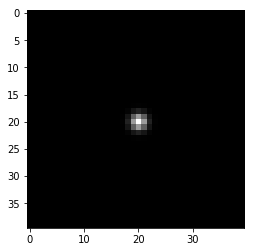

In [6]:
def artificial_psf(size_of_psf = 81, std_gauss = 1.0):  
    filt = np.zeros((size_of_psf, size_of_psf))
    p = (size_of_psf - 1)//2
    filt[p,p] = 1
    filt = torch.tensor(gaussian_filter(filt,std_gauss).reshape(1,1,size_of_psf,size_of_psf).astype(np.float32))
    filt = filt/torch.sum(filt)
    return filt

psf_tensor = artificial_psf(std_gauss = 1.0)
plt.imshow(psf_tensor[0, 0, 20:60, 20:60], cmap = 'gray', interpolation= 'none')

## Show some training data

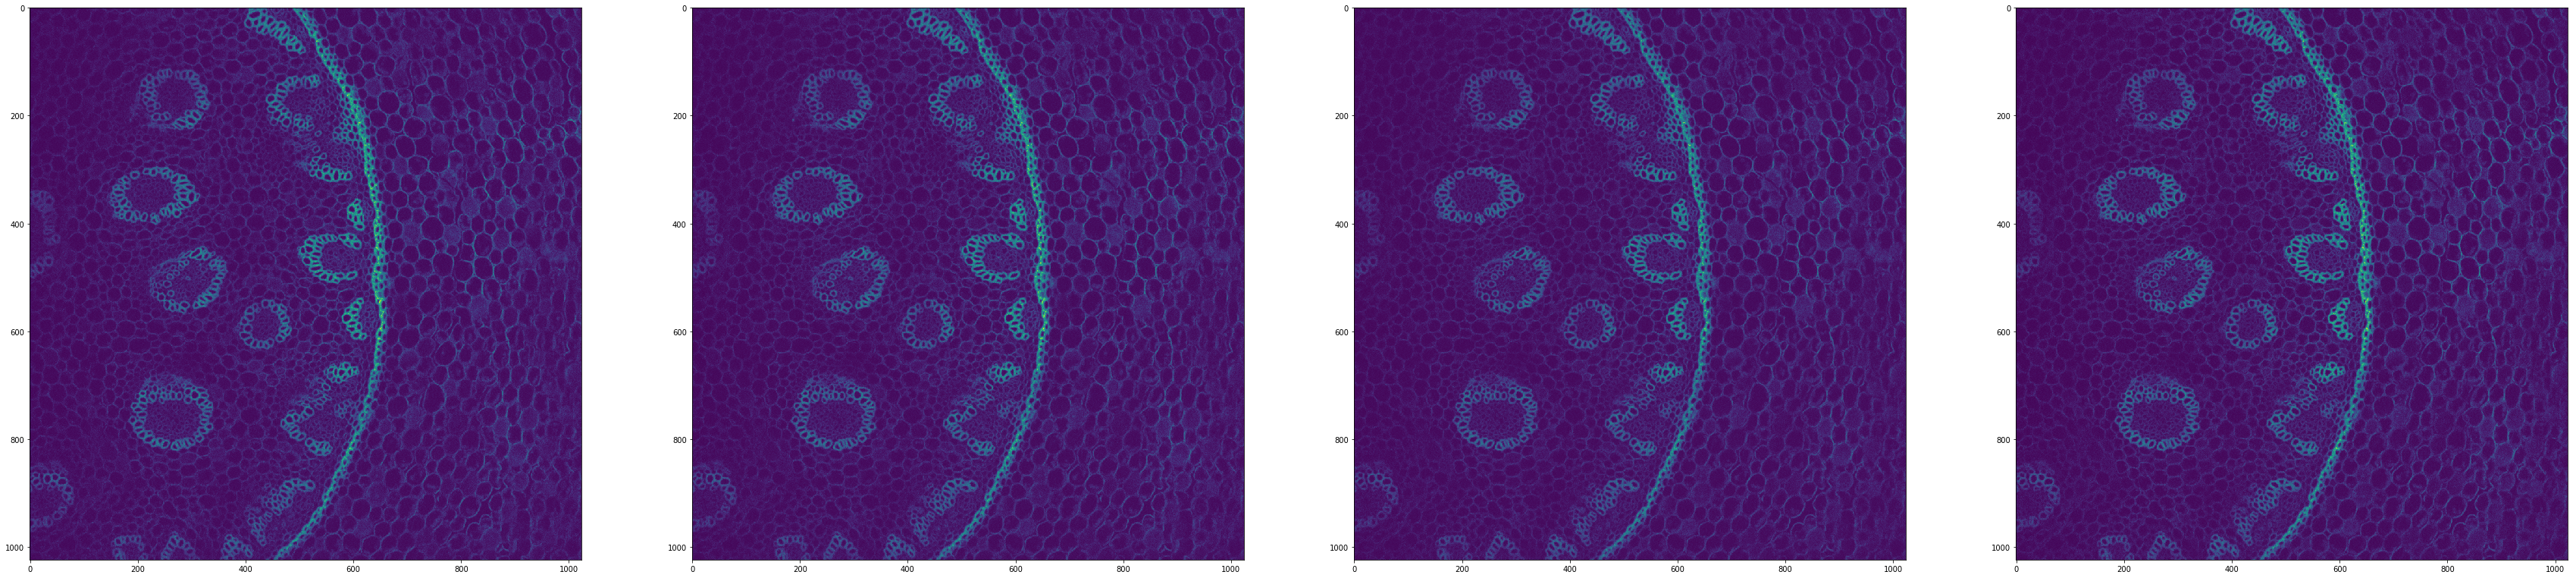

In [7]:
plt.figure(figsize=(60,20))
plt.subplot(141)
plt.imshow(data[0])
plt.subplot(142)
plt.imshow(data[1])
plt.subplot(143)
plt.imshow(data[2])
plt.subplot(144)
plt.imshow(data[3])
plt.show()

## Create the Network and Train it
This can take a while. Before the run, you can adjust parameters, such as Number of Epochs, Steps per Epoch, Virtual Batch Size, Batch Size, Learning Rate, and our new parameter - Positivity Constraint, which can be turned of by setting it to 0. 
Note that you can improve the results at the cost of training time by increasing 'batchSize' or 'stepsPerEpoch'.

In [8]:
# The network requires only a single output unit per pixel
net = UNet(1, depth=3)
net.psf=psf_tensor.to(device)
# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net = net, trainData = my_train_data, valData = my_val_data,
                                           postfix = nameModel, directory = path,
                                           device = device, numOfEpochs = 200, stepsPerEpoch = 10, 
                                           virtualBatchSize = 20, batchSize = 1, learningRate = 1e-3,
                                        psf = psf_tensor.to(device),positivity_constraint = 1)

/home/krull/projects/DecoNoisingTest/DecoNoising/unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/krull/projects/DecoNoisingTest/DecoNoising/unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 0.5227455481886863+-(2SEM)0.2077567105116563      
Epoch 1 finished      
avg. loss: 0.17842242885380982+-(2SEM)0.07128307801813795      
Epoch 2 finished      
avg. loss: 0.14965021498501302+-(2SEM)0.03923813432855319      
Epoch 3 finished      
avg. loss: 0.17046715449541808+-(2SEM)0.04344898706342951      
Epoch 4 finished      
avg. loss: 0.15697445087134837+-(2SEM)0.041402689569959635      
Epoch 5 finished      
avg. loss: 0.15721540041267873+-(2SEM)0.03916935380252926      
Epoch 6 finished      
avg. loss: 0.14013925921171905+-(2SEM)0.04376261822930651      
Epoch 7 finished      
avg. loss: 0.1550004445016384+-(2SEM)0.042956298373626176      
Epoch 8 finished      
avg. loss: 0.16098440550267695+-(2SEM)0.05272143622706261      
Epoch 9 finished      
avg. loss: 0.1610827600583434+-(2SEM)0.040735636189798426      
Epoch 10 finished      
avg. loss: 0.13892308436334133+-(2SEM)0.05733330302498213      
Epoch 11 finished      
avg. loss: 0.113165

Epoch 90 finished      
avg. loss: 0.09182602874934673+-(2SEM)0.01724025677192061      
Epoch 91 finished      
avg. loss: 0.11147113740444184+-(2SEM)0.025165671418565034      
Epoch 92 finished      
avg. loss: 0.13610444571822883+-(2SEM)0.032437450264294725      
Epoch 93 finished      
avg. loss: 0.10188500555232168+-(2SEM)0.014898945220646937      
Epoch 94 finished      
avg. loss: 0.10770873930305243+-(2SEM)0.01920714438958062      
Epoch 95 finished      
avg. loss: 0.14147260449826718+-(2SEM)0.035072199224577175      
Epoch    95: reducing learning rate of group 0 to 1.5625e-05.
Epoch 96 finished      
avg. loss: 0.12446903008967639+-(2SEM)0.031706335693260715      
Epoch 97 finished      
avg. loss: 0.1245491124689579+-(2SEM)0.024139595207410377      
Epoch 98 finished      
avg. loss: 0.12493517864495515+-(2SEM)0.034552219017891975      
Epoch 99 finished      
avg. loss: 0.12703042440116405+-(2SEM)0.030125793630486845      
Epoch 100 finished      
avg. loss: 0.0943379981443

Epoch 177 finished      
avg. loss: 0.11521131955087185+-(2SEM)0.025245445507849663      
Epoch 178 finished      
avg. loss: 0.13483615238219498+-(2SEM)0.03629472814695293      
Epoch 179 finished      
avg. loss: 0.10113425273448229+-(2SEM)0.029984061299917868      
Epoch 180 finished      
avg. loss: 0.09579607024788857+-(2SEM)0.017187593898293392      
Epoch 181 finished      
avg. loss: 0.13797118701040745+-(2SEM)0.0334907789972208      
Epoch   181: reducing learning rate of group 0 to 1.2207e-07.
Epoch 182 finished      
avg. loss: 0.1185998609289527+-(2SEM)0.03235350947671435      
Epoch 183 finished      
avg. loss: 0.12550962660461665+-(2SEM)0.027450567413529428      
Epoch 184 finished      
avg. loss: 0.140858512558043+-(2SEM)0.0429075068081441      
Epoch 185 finished      
avg. loss: 0.1404099466279149+-(2SEM)0.03241975202315632      
Epoch 186 finished      
avg. loss: 0.1105028972029686+-(2SEM)0.03069785199440763      
Epoch 187 finished      
avg. loss: 0.1424632191658

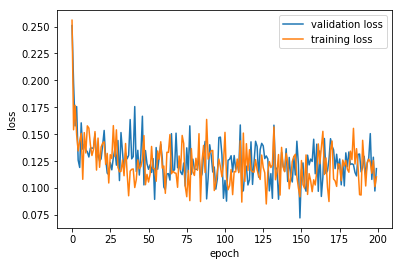

In [9]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()